## License 

Copyright 2017 - 2019 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Testing machine learning models for accuracy, trustworthiness, and stability with Python and H2O
#### Performing residual analysis and sensitivity analysis to validate complex models

This notebook provides a basic introduction to two traditional data analysis and model diagnostic techniques that can be applied to machine learning models: residual analysis and sensitivity analysis. The notebook starts by loading the UCI credit card default dataset and using h2o to train a GBM model to predict credit card defaults. Then, residual analysis is used to discover and debug an issue with the GBM, and the GBM is retrained and improved. The notebook concludes by conducting sensitivity analysis to test the GBM credit card default model for fairness and stability. 

#### Start H2O cluster

The `os` commands below check whether this notebook is being run on the Aquarium platform. 

In [1]:
import os

startup = '/home/h2o/bin/aquarium_startup'
if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
    !sleep 5
else:
    local_url = 'http://localhost:54321'
    aquarium = False

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [2]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

pd.options.display.max_columns = 999 # enable display of all columns in notebook

# plotting functionality
import matplotlib.pyplot as plt
import seaborn as sns

# display plots in notebook
%matplotlib inline

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 2, but the server still needs to be started.

>The parameters used in `h2o.init` will depend on your specific environment. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

In [3]:
h2o.init(url=local_url, max_mem_size='2G')
h2o.remove_all()    # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321/h2o . connected.


H2O cluster uptime:,26 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 10 days
H2O cluster name:,h2o
H2O cluster total nodes:,1
H2O cluster free memory:,13.34 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data (REWRITE)

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path, skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'Default'})

Rename data fields and censor data appropriately

In [5]:
data = data.rename(columns = {
    'LIMIT_BAL': 'CreditLimit',
    'SEX': 'Sex',
    'EDUCATION': 'Education',
    'MARRIAGE': 'Marriage',
    'AGE': 'Age',
    'PAY_0': 'Status1',
    'PAY_2': 'Status2',
    'PAY_3': 'Status3',
    'PAY_4': 'Status4',
    'PAY_5': 'Status5',
    'PAY_6': 'Status6',
    'BILL_AMT1': 'BillAmt1',
    'BILL_AMT2': 'BillAmt2',
    'BILL_AMT3': 'BillAmt3',
    'BILL_AMT4': 'BillAmt4',
    'BILL_AMT5': 'BillAmt5',
    'BILL_AMT6': 'BillAmt6',
    'PAY_AMT1': 'PayAmt1',
    'PAY_AMT2': 'PayAmt2',
    'PAY_AMT3': 'PayAmt3',
    'PAY_AMT4': 'PayAmt4',
    'PAY_AMT5': 'PayAmt5',
    'PAY_AMT6': 'PayAmt6',
})

## Censor data (to ensure that we are using only what we know at the time of prediction)
##   For Status1, replace any values >= 1 with 1
##   ...
##   For Status6, replace any values >= 6 with 6

data['Status1'][data['Status1']>1] = 1
data['Status2'][data['Status2']>2] = 2
data['Status3'][data['Status3']>3] = 3
data['Status4'][data['Status4']>4] = 4
data['Status5'][data['Status5']>5] = 5
data['Status6'][data['Status6']>6] = 6

## Truncate StatusX negative values to 0 since we treat StatusX as numeric below

statuses = ['Status1', 'Status2', 'Status3', 'Status4', 'Status5', 'Status6']

for status in statuses:
    data[status][data[status]<0] = 0

sex_dict = {1:'M', 2:'F'}
data['Sex'] = data['Sex'].apply(lambda i: sex_dict[i])

marriage_dict = {0:'O', 1:'M', 2:'S', 3:'D'}
data['Marriage'] = data['Marriage'].apply(lambda i: marriage_dict[i])

#### Helper function for recoding values in the UCI credict card default data [REWRITE]

These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [6]:
data = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [7]:
# assign target and inputs for GBM
y = 'Default'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = Default
X = ['CreditLimit', 'Sex', 'Education', 'Marriage', 'Age', 'Status1', 'Status2', 'Status3', 'Status4', 'Status5', 'Status6', 'BillAmt1', 'BillAmt2', 'BillAmt3', 'BillAmt4', 'BillAmt5', 'BillAmt6', 'PayAmt1', 'PayAmt2', 'PayAmt3', 'PayAmt4', 'PayAmt5', 'PayAmt6']


#### Ensure target is handled as a categorical variable
In H2O, a numeric variable can be treated as numeric or categorical. The target variable `Default` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [8]:
data[y] = data[y].asfactor() 

#### Ensure Education and Status1-Status6 are handled as categorical variables

In [9]:
##num_to_categorical = ['Education', 'Status1', 'Status2', 'Status3', 'Status4', 'Status5', 'Status6']
#num_to_categorical = ['Education']
#for name in num_to_categorical:
#    data[name] = data[name].asfactor()

#### Display descriptive statistics
The h2o `describe()` function displays a brief description of the credit card default data. For the categorical input variables `CreditLimit`, `Sex`, `Education`, `Marriage`, and `Status1`-`Status6`, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs.

In [10]:
data.describe()

Rows:30000
Cols:25




,ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default
type,int,int,enum,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,0.0,,21.0,0.0,0.0,0.0,0.0,0.0,0.0,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666673,,1.8531333333333393,,35.48549999999956,0.22726666666666667,0.29493333333333327,0.2937333333333309,0.2511999999999998,0.21740000000000032,0.22489999999999963,51223.33090000043,49179.07516666629,47013.154799999655,43262.94896666659,40311.40096666682,38871.76039999976,5663.580500000035,5921.163499999979,5225.681499999981,4826.076866666652,4799.387633333336,5215.50256666665,
maxs,30000.0,1000000.0,,6.0,,79.0,1.0,2.0,3.0,4.0,5.0,6.0,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720246,,0.7903486597207269,,9.217904068090155,0.41907324296394916,0.7084944561312378,0.7348959549653103,0.7087420573406523,0.6839245804626852,0.7005733485990058,73635.86057552966,71173.76878252832,69349.38742703677,64332.856133916444,60797.15577026471,59554.1075367459,16563.28035402577,23040.87040205719,17606.96146980311,15666.159744032062,15278.305679144742,17777.46577543531,
zeros,0,0,,14,,0,23182,25562,25787,26490,27032,26921,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,F,2.0,M,24.0,1.0,2.0,0.0,0.0,0.0,0.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,F,2.0,S,26.0,0.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,F,2.0,S,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [11]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations. 

In [12]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7735


#### Display variable importance
During training, the h2o GBM aggregates the improvement in error caused by each split in each decision tree across all the decision trees in the ensemble classifier. These values are attributed to the input variable used in each split and give an indication of the contribution each input variable makes toward the model's predictions. The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, a customer's most recent payment behavior, `PAY_0`, is by far the most important variable followed by their second most recent payment, `PAY_2`, their credit limit, `LIMIT_BAL`, and third most recent payment behavior, `PAY_3`. This result is well-aligned with business practices in credit lending: people who miss their most recent payments are likely to default soon.

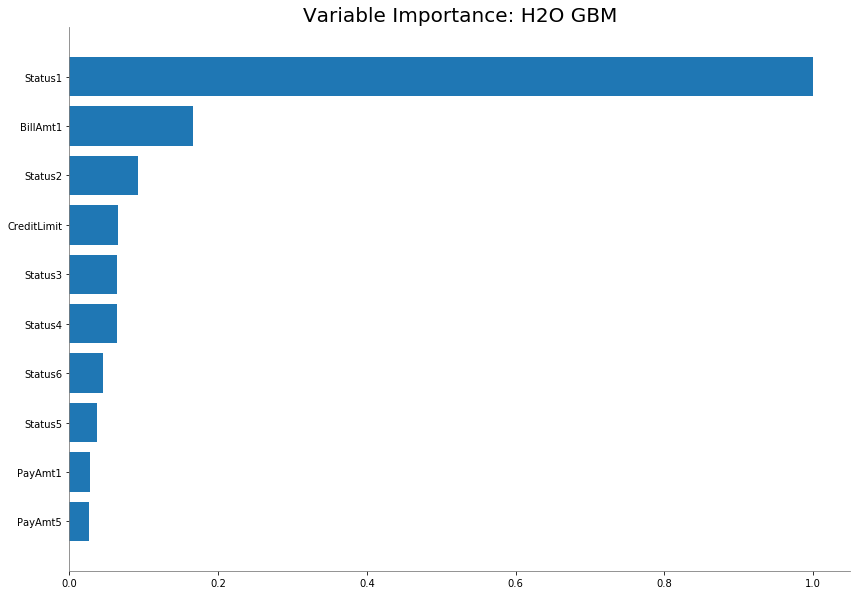

In [13]:
model.varimp_plot()

## 3. Conduct residual analysis to debug model
Residuals refer to the difference between the recorded value of a dependent variable and the predicted value of a dependent variable for every row in a data set. Plotting the residual values against the predicted values is a time-honored model assessment technique and a great way to see all your modeling results in two dimensions.

#### Bind model predictions onto test data 
To calculate the residuals for our GBM model, first the model predictions are merged onto onto the test set. The test data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing residuals for the training inputs and predictions.

In [14]:
yhat = 'p_Default'
preds1 = model.predict(test).drop(['predict', 'p0'])
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Calculate deviance residuals for binomial classification
For binomial classification, deviance residuals are related to the logloss cost function. Like analyzing $y - \hat{y}$ for linear regression, these residuals are the quantities that the GBM sought to minimize. Deviance residual values are calculated by applying the simple formula in the cell directly below.

In [15]:
# use Pandas for adding columns and plotting
test_yhat = test_yhat.as_data_frame()
test_yhat['s'] = 1
test_yhat.loc[test_yhat['Default'] == 0, 's'] = -1
test_yhat['r_Default'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

#### Plot residuals
Plotting residuals is a model debugging and diagnostic tool that enables users to see modeling results, and any anomolies, in a single two-dimensional plot. Here the green points represent customers who defaulted, and the blue points represent customers who did not. A few potential outliers are visible. There appear to be several cases in the test data with relatively large negative residuals. Understanding and addressing the factors that cause these outliers could lead to a more acccurate model.

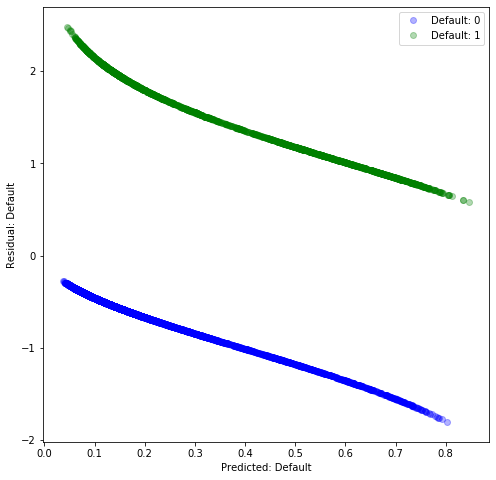

In [16]:
groups = test_yhat.groupby('Default') # define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          # initialize figure

plt.xlabel('Predicted: Default')
plt.ylabel('Residual: Default')

# plot groups with appropriate color
color_list = ['b', 'g'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group.p_Default, group.r_Default, label=' '.join(['Default:', str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) # legend

#### Sort data by residuals and display data and residuals
Printing a table with model inputs, actual target values, and model predictions sorted by residuals is another simple way to analyze residuals. Customers that defaulted, but were predicted not to, are listed at the top of the table below. Scroll to the bottom of the table to see the customers who were predicted to default, but then did not. Also notice the jumps in residual values. These are the potential outliers pictured in the residual plot above. 

In [17]:
test_yhat = test_yhat.sort_values(by='r_Default', ascending=False).reset_index(drop=True)
test_yhat

,ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,p_Default,r_Default
0,2561,310000,F,1,S,32,0,0,0,0,0,0,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.045917,2.482305
1,8339,480000,M,1,M,58,0,0,0,0,0,0,24610,-310,148544,18791,5909,68988,4,149654,18885,5940,69337,200655,1,0.047749,2.466496
2,6933,500000,M,1,S,37,0,0,0,0,0,0,4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.050744,2.441706
3,25772,350000,F,1,M,33,0,0,0,0,0,0,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.051426,2.436231
4,22505,260000,F,2,S,33,0,0,0,0,0,0,5188,12357,28656,7497,7685,15434,13000,29022,7500,27769,12000,6200,1,0.051968,2.431921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8935,9672,170000,M,1,S,48,1,2,3,4,5,6,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,0,0.782549,-1.746872
8936,14589,280000,M,1,M,50,1,2,3,3,2,0,327918,321476,314931,176439,154010,134334,0,0,500,0,6267,2257,0,0.785610,-1.754969
8937,16957,270000,M,1,M,50,1,2,3,3,2,2,213616,208784,212058,207226,202394,231339,0,8000,0,0,32236,3000,0,0.786637,-1.757703
8938,26512,100000,F,3,M,55,1,2,2,0,3,2,1520,1349,959,1623,1470,930,0,0,1623,0,0,780,0,0.791979,-1.772071


This simple analysis has uncovered some of the most difficult customers for the GBM to correctly predict default. Perhaps because of the high importance of the payment features, `PAY_0`-`PAY_6`, the GBM struggles to correctly predict several cases in which customers made timely recent payments and then suddenly defaulted (high positive residuals) and those customers that were chronically late making payments but did not default (high negative residuals).

#### Plot residuals by most important input variable 
Residuals can also be plotted for important input variables to understand how the values of a single input variable affect prediction errors. When plotted by `PAY_0`, the residuals confirm that the GBM is struggling to accurately predict cases where default status is not correlated with recent payment behavior in an obvious way. The residual plots for values of `PAY_0` indicating timely payment behavior (e.g., `use of revolving credit`, `pay duly`, and `no consumption`) generally display the highest positive residuals and relatively small negative residuals. Residuals for the other values of `PAY_0`, those that represent late recent payments, tend to show large negative residuals and relatively small positive residuals.

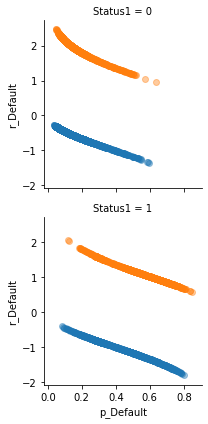

In [18]:
# use Seaborn FacetGrid for convenience
g = sns.FacetGrid(test_yhat, row='Status1', hue=y)
_ = g.map(plt.scatter, yhat, 'r_Default', alpha=0.4)

## 4. Retrain GBM classifier based on results of residual analysis
Now that an issue has been discovered using residual analysis, can it be resolved? 

#### Create a feature that contains information about behavior over time
One strategy to improve prediction accuracy is to introduce a new feature that summarizes a customer's spending behavior over time to expose any potential financial instability: the standard deviation of a customer's bill amounts over six months. Pandas has a one-liner for calculating standard deviations for a set of columns, so the H2OFrame is casted back into Pandas DataFrame for convenience.

In [19]:
data = data.as_data_frame()
data['bill_std'] = data[['BillAmt1', 'BillAmt2', 'BillAmt3', 'BillAmt4', 'BillAmt5', 'BillAmt6']].std(axis=1)
data.head(n=3)

,ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std
0,1,20000,F,2,M,24,1,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1761.633219
1,2,120000,F,2,S,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,637.967841
2,3,90000,F,2,S,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,6064.518593


#### Convert Pandas DataFrame back to H2OFrame for modeling
To retrain the model with the new feature, an H2OFrame is required and that H2OFrame is split using the same proportion and random seed as in cell 8 for the first GBM model.

In [20]:
data = h2o.H2OFrame(data)                          # convert 
data[y] = data[y].asfactor()                       # ensure target is handled as a categorical variable
train, test = data.split_frame([0.7], seed=12345)  # split into training and validation

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Retrain GBM with new feature
The `train()` function is used to retrain the GBM model with the nearly same hyperparameters used previously in cell 9. A slight, but noticable, increase in accuracy results from retraining with the new feature. 

In [21]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=6,           # trees can have maximum depth of 6
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.85,  # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # for reproducibility

# retrain GBM model
model.train(y=y,
            x=X + ['bill_std'], # add new feature
            training_frame=train, 
            validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7756


While there maybe be other more complex features or a more optimal set of hyperparameters that could lead to further incremental increases in accuracy, more information is needed to achieve meaningful improvement in prediction performance. In particular, a common measure for credit lending, the customers' debt-to-income ratio, for each payment and billing period could be particularly useful. Spikes in debt-to-income ratio, representing loss of income or large increases in debt, would likely be very indicative of a default and would expose the GBM to information not currently available in the UCI credit card default data. Introducing new data could also de-emphasize `PAY_0`, which would likely result in a more stable model as well.

## 5. Perform sensitivity analysis to test model performance on unseen data

Sensitivity analysis investigates whether model behavior and outputs remain stable when data is intentionally perturbed or other changes are simulated in data. Beyond traditional assessment practices, sensitivity analysis of machine learning model predictions is perhaps the most important validation technique for machine learning models. Machine learning models can make drastically differing predictions for only minor changes in input variable values. In practice, many linear model validation techniques focus on the numerical instability of regression parameters due to correlation between input variables or between input variables and the dependent variable. It may be prudent for those switching from linear modeling techniques to machine learning techniques to focus less on numerical instability of model parameters and to focus more on the potential instability of model predictions.

Here sensitivity analysis is used to understand the impact of  changing the most important input variable, `PAY_0`, and the impact of a sociologically sensitive variable, `SEX`, in the model. If the model changes in reasonable and expected ways when important variable values are changed this can enhance trust in the model. If the contribution of potentially sensitive variables, such as those related to gender, race, age, marital status, or disability status, can be shown to have minimal impact on the model, this is an indication of fairness in the model predictions and can also increase overall trust in the model.

#### Bind new model predictions onto test data 
Typically, a productive exercise in model debugging and validation is to investigate customers with very high or low predicted probabilities to determine if their predictions stay within reasonable bounds when important variables are changed. The predictions from the new, more accurate model are merged onto the test set to find these potentially interesting customers. 

In [22]:
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Helper function for finding percentile indices
The function below finds and returns the row indices for the minimum, the maximum, and the deciles of one column in terms of another -- in this case, the model predictions (`p_DEFAULT_NEXT_MONTH`) and the row identifier (`ID`), respectively. These indices are used as a starting point for boundary testing. Outlying predictions found through residual analysis is another group of potentially interesting local predictions to investigate.

In [23]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the minimum, the maximum, and the deciles of a column, yhat, 
        as the indices based on another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: H2OFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.as_data_frame()
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
pred_percentile_dict = get_percentile_dict(yhat, 'ID', test_yhat)
pred_percentile_dict

{0: 7041,
 99: 7857,
 10: 288,
 20: 20099,
 30: 8897,
 40: 8289,
 50: 6780,
 60: 4923,
 70: 6985,
 80: 10251,
 90: 3823}

#### Display test data prediction range
Unlike some regression models and neural networks that can produce outrageous predictions for changes in input variables, GBM predictions in new data are bounded by the lowest and highest probability leaf nodes in each constiuent decision tree in the trained model. While unbounded, extreme predictions are typically not an issue for tree models and classification tasks, it is often a good idea to check that the model predictions cover a full range of useful values in the test set. Below, we can see that the model produces both low and high predictions in the test set, indicating that it is likely responsive to signal in new data and not simply predicting the majority class or an average value. 

In [24]:
print('Lowest prediction:', test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])][[y, yhat]])
print('Highest prediction:', test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])][[y, yhat]])

Lowest prediction: 

Default,p_Default
0,0.0374856



Highest prediction: 

Default,p_Default
1,0.846665


#### Use trained model to test predictions for interesting situations: customer least likely to default
As a starting point for further analysis, sensitivity analysis is performed for the customer least likely to default. This woman has a very low probability of defaulting according to the trained GBM.

In [25]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case

ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,p_Default
7041,500000,F,1,M,39,0,0,0,0,0,0,39823,61597,52210,27843,28926,11931,30006,23016,566,22323,11931,10683,0,18010,0.0374856


#### Test effect of changing `Sex`

`Sex` should not have a large impact on predictions. This could indicate unwanted sociological bias in the GBM model.

In [26]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat])
test_case['Sex'] = 'M'
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,predict,p0,p1
7041,500000,M,1,M,39,0,0,0,0,0,0,39823,61597,52210,27843,28926,11931,30006,23016,566,22323,11931,10683,0,18010,0,0.966138,0.033862


As desired, simulating this person as a male does not have a large impact on their probability of default.

#### Test effect of changing `Status1` [rewrite]

Variable importance and residual analysis indicates that the value of `Status1` can have a strong effect on model predictions. Measuring the change in predicted probability when the value of `Status1` is changed from a timely payment to late payment is probably a good test case for prediction stability. 

In [28]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat])
test_case['Status1'] = 1 
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,predict,p0,p1
7041,500000,F,1,M,39,1,0,0,0,0,0,39823,61597,52210,27843,28926,11931,30006,23016,566,22323,11931,10683,0,18010,0,0.909453,0.0905475


When the value is changed from `-2` to `2` there is a very large increase in predicted probability. Such a marked change related to the value of one variable is problematic for numerous reasons.

#### Use trained model to test predictions for interesting situations: customer most likely to default

Now the same test will be performed on the customer most likely to default. This woman has a very high probability of default under the GBM model. 

In [31]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case

ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,p_Default
7857,300000,F,1,S,25,1,2,3,3,2,3,315632,309330,302869,306395,311256,305413,0,0,10000,10000,0,0,1,4578.58,0.846665


#### Test effect of changing `Sex`
Changing the value for `Sex` from female to male for this customer decreases the predicted probability by a relatively small amount.

In [32]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat])
test_case['Sex'] = 'M'
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,predict,p0,p1
7857,300000,M,1,S,25,1,2,3,3,2,3,315632,309330,302869,306395,311256,305413,0,0,10000,10000,0,0,1,4578.58,1,0.233259,0.766741


#### Test effect of changing `Status1`
Switching the riskiest customer's value for `Status1` from `1` to `0` reduces the their chance of default by about 20%, a noticable swing in probability but still a higher probability value, notably greater than common lending cutoffs.

In [33]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat])
test_case['Status1'] = 0
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,CreditLimit,Sex,Education,Marriage,Age,Status1,Status2,Status3,Status4,Status5,Status6,BillAmt1,BillAmt2,BillAmt3,BillAmt4,BillAmt5,BillAmt6,PayAmt1,PayAmt2,PayAmt3,PayAmt4,PayAmt5,PayAmt6,Default,bill_std,predict,p0,p1
7857,300000,F,1,S,25,0,2,3,3,2,3,315632,309330,302869,306395,311256,305413,0,0,10000,10000,0,0,1,4578.58,1,0.267241,0.732759


From this small number of boundary test cases, the GBM model appears stable. However, if large swings in predictions occur for sensitive or important variables, practicioners are urged to retrain unstable models without the problematic variables or combinations of variables, which may unfortunately involve some trial and error. Also, four test cases is woefully inadequate for real-world models. Automated sensitivity analysis across many variables, combinations of variables, and for many different rows of data seems more appropriate for mission-critical machine learning.

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models, H2OFrames, or scoring artifacts, such as POJOs or MOJOs.

In [34]:
# be careful, this can erase your work!
h2o.cluster().shutdown()

H2O session _sid_ba50 closed.


#### Summary

In this notebook, a complex GBM classifier was trained to predict credit card defaults. Residual analysis was used to debug the GBM model predictions and enabled a slight improvement in accuracy. Sensitivity analysis was used to test the GBM for trustworthiness and stability. In a small number of boundary test cases, the trained GBM appeared stable. Residual analysis and sensitivity analysis are powerful model debugging techniques and can increase trust in complex models. These techniques should generalize well for many types of business and research problems, enabling you to train a complex model and justify it to your colleagues, bosses, and potentially, external regulators. 